In [10]:
import json
import os
import numpy as np
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import SVI, TraceMeanField_ELBO
from numpyro.infer.autoguide import AutoNormal
from numpyro.optim import Adam
import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy.special import expit  # sigmoid


In [11]:
# helpers
def binomial(n_samples, theta_like=0.7, seed=20):
    np.random.seed(seed)
    data = np.random.binomial(n_samples, theta_like)
    return data

def load_config(config_file="config.json"):

    with open(config_file, 'r') as f:
        config = json.load(f)
    return config

def _logistic_normal_mean_std_mc(mu, sigma, n_samples=10_000, seed=0):
    mu = float(np.squeeze(mu))
    sigma = float(np.squeeze(sigma))
    rng = np.random.default_rng(seed)
    z = rng.normal(loc=mu, scale=sigma, size=n_samples)
    theta = expit(z)
    return float(theta.mean()), float(theta.std(ddof=1))

def _trace_locscale_to_theta_moments(loc_trace, scale_trace, n_samples=10_000, seed=0):
    loc_trace = np.asarray(loc_trace, dtype=float)
    scale_trace = np.asarray(scale_trace, dtype=float)
    out_mean = np.empty(loc_trace.shape[0], dtype=float)
    out_std  = np.empty(loc_trace.shape[0], dtype=float)
    for i in range(loc_trace.shape[0]):
        out_mean[i], out_std[i] = _logistic_normal_mean_std_mc(
            loc_trace[i], scale_trace[i], n_samples=n_samples, seed=seed
        )
    return out_mean, out_std

data_gen = binomial

In [12]:
config_file = "beta_config.json"
config = load_config(config_file)

theta_like = config['theta_like']
alpha_prior = config['alpha_prior']
beta_prior = config['beta_prior']
n_samples = config['n_samples']
max_iters = 50_000
adam_step = config['adam_step']

data = data_gen(n_samples) if n_samples > 0 else 0


In [13]:
# run in numpyro 
def model(y):
    theta = numpyro.sample("theta", dist.Beta(alpha_prior, beta_prior))
    numpyro.sample("obs", dist.Binomial(n_samples, theta), obs=y)
y_data = jnp.array(data)
optimizer = Adam(step_size=adam_step)

single_mc_elbo = TraceMeanField_ELBO()
multi_mc_elbo = TraceMeanField_ELBO(num_particles=100)

single_mc_guide = AutoNormal(model)
multi_mc_guide = AutoNormal(model)

single_mc_svi = SVI(model, single_mc_guide, optimizer, loss=single_mc_elbo)
multi_mc_svi = SVI(model, multi_mc_guide, optimizer, loss=multi_mc_elbo)

def run_svi(rng_key, y_data, svi_model):
    @jax.jit
    def run_single_svi_loop(rng_key, y_data):
        svi_state = svi_model.init(rng_key, y_data)
        def body_fn(i, val):
            svi_state, tracker = val
            svi_state, loss = svi_model.update(svi_state, y_data)
            params = svi_model.get_params(svi_state)
            tracker = {
                'mu_loc': tracker['mu_loc'].at[i].set(params['theta_auto_loc']),
                'std_loc': tracker['std_loc'].at[i].set(params['theta_auto_scale'])
            }
            return svi_state, tracker
        tracker = {
            'mu_loc': jnp.zeros(max_iters),
            'std_loc': jnp.zeros(max_iters)
        }
        final_state, final_tracker = jax.lax.fori_loop(0, max_iters, body_fn, (svi_state, tracker))
        final_elbo = svi_model.evaluate(final_state, y_data)
        return final_elbo, final_tracker
    return run_single_svi_loop(rng_key, y_data)

single_elbo, single_tracker = run_svi(jax.random.PRNGKey(0), y_data, single_mc_svi)
multi_elbo, multi_tracker = run_svi(jax.random.PRNGKey(10), y_data, multi_mc_svi)

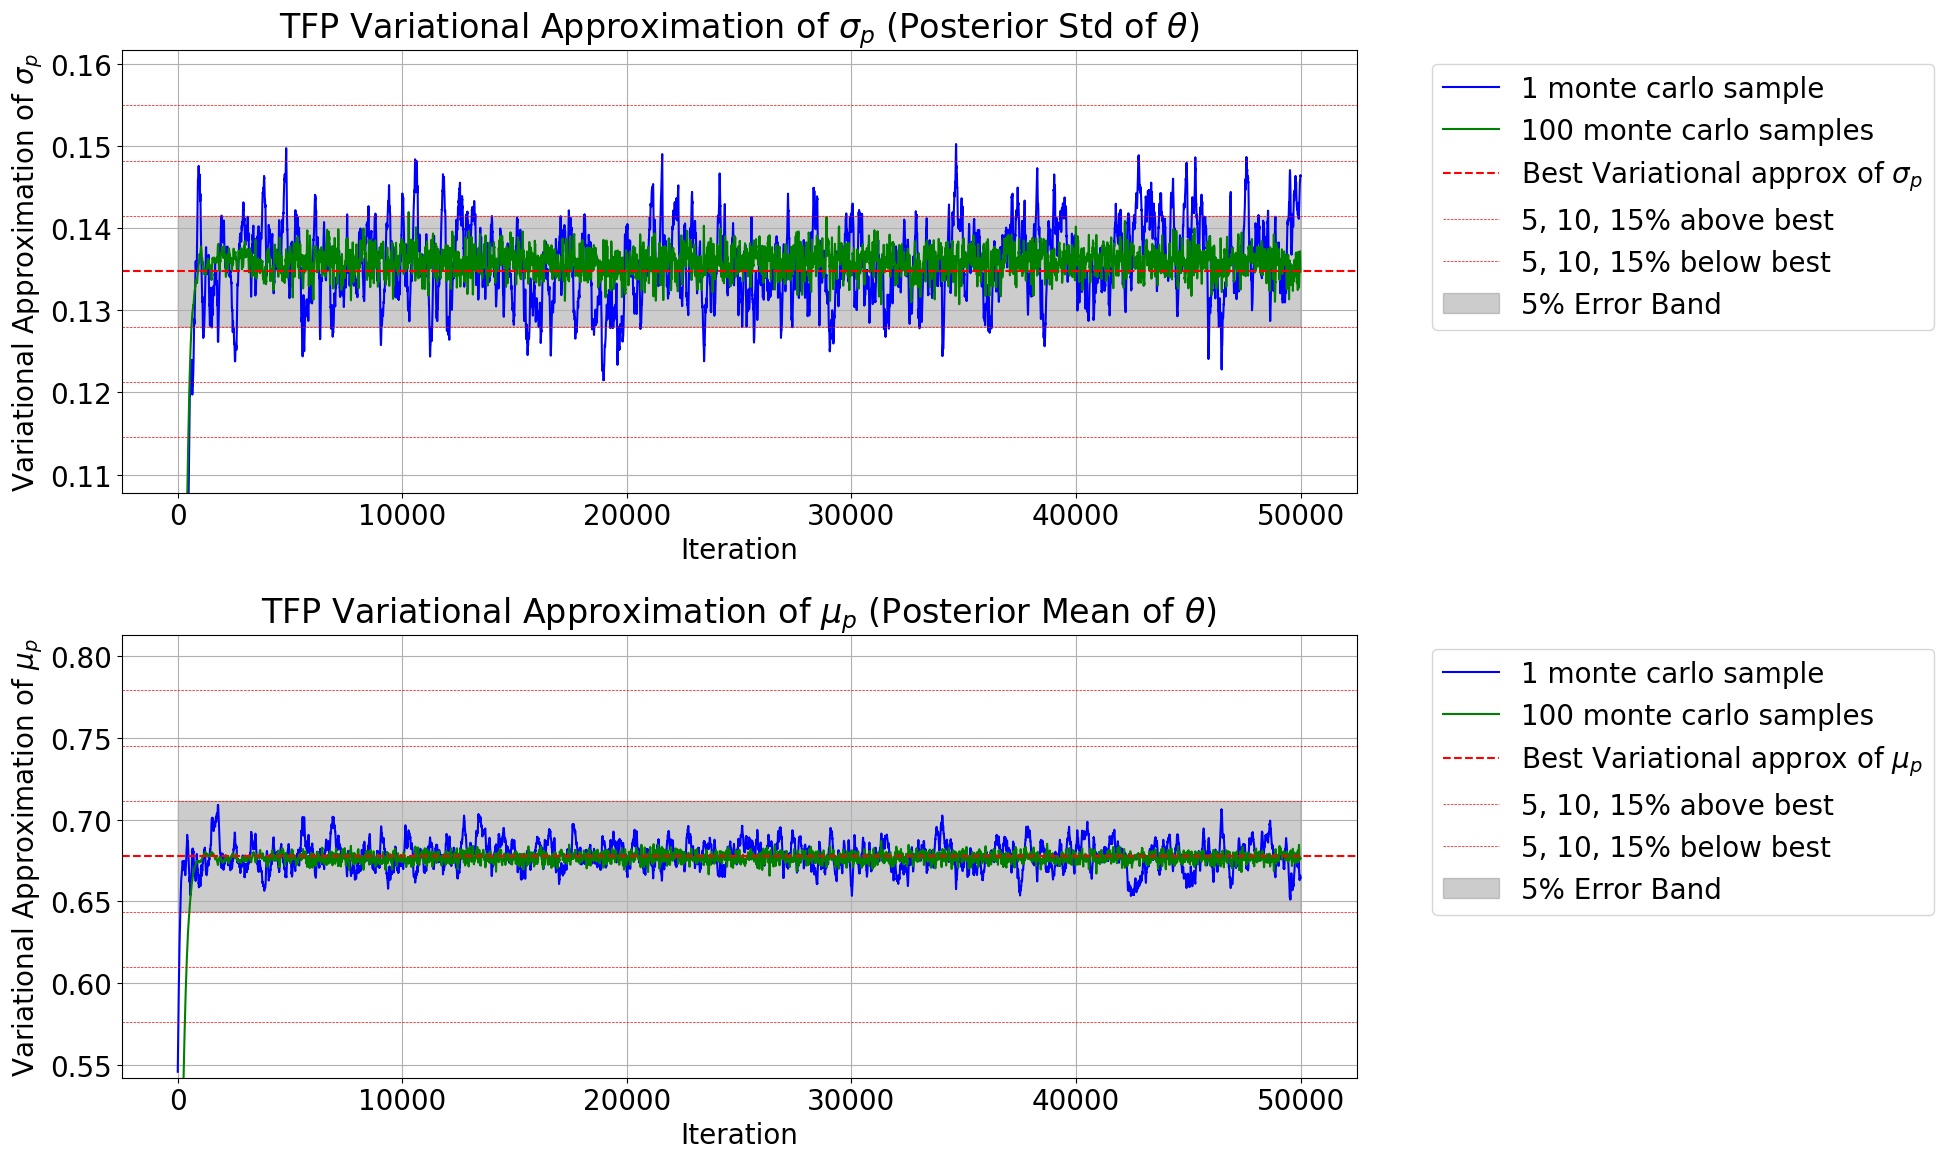

In [14]:
plt.rcParams.update({'font.size': 20})

# plot against the "best_mean" and "best_std" transformed by "transformation" from the config file,
best_mu = config['best_mean']
best_std = config['best_std']
# best_mu, best_std = _logistic_normal_mean_std_mc(best_mu, best_std, n_samples=50_000, seed=1)

single_theta_mean, single_theta_std = _trace_locscale_to_theta_moments(
    single_tracker['mu_loc'], single_tracker['std_loc'], n_samples=10000, seed=0
)
multi_theta_mean, multi_theta_std = _trace_locscale_to_theta_moments(
    multi_tracker['mu_loc'], multi_tracker['std_loc'], n_samples=10000, seed=0
)
single_mus, single_stds = [], []
multi_mus, multi_stds = [], []

for i in range(len(single_tracker['mu_loc'])):
    m, s = _logistic_normal_mean_std_mc(single_tracker['mu_loc'][i], single_tracker['std_loc'][i], n_samples=10_000, seed=0)
    single_mus.append(m)
    single_stds.append(s)

    m, s = _logistic_normal_mean_std_mc(multi_tracker['mu_loc'][i], multi_tracker['std_loc'][i], n_samples=10_000, seed=0)
    multi_mus.append(m)
    multi_stds.append(s)

single_mus = np.array(single_mus)
single_stds = np.array(single_stds)
multi_mus = np.array(multi_mus)
multi_stds = np.array(multi_stds)

# If you have "best" from config, these should be on theta-scale (0,1)
best_mu = float(config["best_mean"]) if "config" in globals() and "best_mean" in config else None
best_std = float(config["best_std"]) if "config" in globals() and "best_std" in config else None
best_mu, best_std = _logistic_normal_mean_std_mc(best_mu, best_std, n_samples=50_000, seed=1)

plt.rcParams.update({"font.size": 20})
fig, axs = plt.subplots(2, 1, figsize=(20, 12))

# Mean(theta) on bottom axis (axs[1])
axs[1].plot(single_mus, label='1 monte carlo sample', color='blue')
axs[1].plot(multi_mus,  label='100 monte carlo samples', color='green')
axs[1].axhline(best_mu, color='red', linestyle='--', label=r'Best Variational approx of $\mu_p$')
axs[1].set_title(fr'TFP Variational Approximation of $\mu_p$ (Posterior Mean of $\theta$)')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel(r'Variational Approximation of $\mu_p$')

# Std(theta) on top axis (axs[0])
axs[0].plot(single_stds, label='1 monte carlo sample', color='blue')
axs[0].plot(multi_stds,  label='100 monte carlo samples', color='green')
axs[0].axhline(best_std, color='red', linestyle='--', label=r'Best Variational approx of $\sigma_p$')
axs[0].set_title(fr'TFP Variational Approximation of $\sigma_p$ (Posterior Std of $\theta$)')
axs[0].set_xlabel('Iteration', fontsize=20)
axs[0].set_ylabel(r'Variational Approximation of $\sigma_p$')

# y-limits (safe clamping for probabilities)
axs[1].set_ylim([max(0.0, best_mu * 0.8),  min(1.0, best_mu * 1.2)])
axs[0].set_ylim([max(0.0, best_std * 0.8), min(0.5, best_std * 1.2)])

# ±5/10/15% bands around best (also clamped)
for i in [5, 10, 15]:
    axs[1].axhline(min(1.0, best_mu * (1 + i/100)), color='red', linestyle='--', linewidth=0.5,
                    label='5, 10, 15% above best' if i == 5 else None)
    axs[1].axhline(max(0.0, best_mu * (1 - i/100)), color='red', linestyle='--', linewidth=0.5,
                    label='5, 10, 15% below best' if i == 5 else None)

    axs[0].axhline(min(0.5, best_std * (1 + i/100)), color='red', linestyle='--', linewidth=0.5,
                    label='5, 10, 15% above best' if i == 5 else None)
    axs[0].axhline(max(0.0, best_std * (1 - i/100)), color='red', linestyle='--', linewidth=0.5,
                    label='5, 10, 15% below best' if i == 5 else None)
axs[1].fill_between(range(max_iters), best_mu*0.95, best_mu*1.05, color='gray', alpha=0.4, label='5% Error Band')
axs[0].fill_between(range(max_iters), best_std*0.95, best_std*1.05, color='gray', alpha=0.4, label='5% Error Band')

axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axs[1].grid()
axs[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axs[0].grid()

plt.tight_layout()
plt.show()
